In [3]:
!pip install -qU pip
!pip install --upgrade seaborn pandas pyathena
!pip install --upgrade numexpr bottleneck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 3.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.2/375.2 kB 4.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.8.3
    Uninstalling numexpr-2.8.3:
      Successfully uninstalled numexpr-2.8.3
  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5


In [9]:
import boto3
from pyathena import connect
import csv

import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
s3 = boto3.client('s3')

In [13]:
bucket_name = 'aai-540-final-data'
response = s3.list_objects_v2(Bucket=bucket_name)
for obj in response['Contents']:
    print(obj['Key'])

athena/results/05d175b5-0fc9-4f48-b944-2224d9cbcff7.txt
athena/results/0ab3f146-93e1-4299-b0bd-6c77a24234ac.txt
athena/results/0b33ffeb-2cef-4edd-868e-a4b9370ce4e3.txt
athena/results/0d908d57-ee7c-4463-b20d-1b10190e01ef.txt
athena/results/0d908d57-ee7c-4463-b20d-1b10190e01ef.txt.metadata
athena/results/17504ef3-8a9d-4085-b961-b717f24fc584.csv
athena/results/17504ef3-8a9d-4085-b961-b717f24fc584.csv.metadata
athena/results/17751a9d-3ca6-420c-a064-b7361148d418.txt
athena/results/185c46ac-3ebe-45ef-af2a-ffa4c707a07d.csv
athena/results/185c46ac-3ebe-45ef-af2a-ffa4c707a07d.csv.metadata
athena/results/18d2b3ab-d91f-4f62-9e1b-164c7daf2997.csv
athena/results/18d2b3ab-d91f-4f62-9e1b-164c7daf2997.csv.metadata
athena/results/1eacba0b-882b-437b-95d1-4d9fce43a185.csv
athena/results/1eacba0b-882b-437b-95d1-4d9fce43a185.csv.metadata
athena/results/1f04672e-c18e-4875-a03c-ec3c35dc9a4e.txt
athena/results/214fd6f2-b77a-43f9-b997-deba4b464eba.txt
athena/results/30fea615-80ab-4e43-9a51-84c60a92a47c.txt
ath

In [14]:
first_data_obj = s3.get_object(Bucket=bucket_name, Key='data/goemotions_1.csv')
second_data_obj = s3.get_object(Bucket=bucket_name, Key='data/goemotions_2.csv')
third_data_obj = s3.get_object(Bucket=bucket_name, Key='data/goemotions_3.csv')
df_1 = pd.read_csv(io.BytesIO(first_data_obj['Body'].read()))
df_2 = pd.read_csv(io.BytesIO(second_data_obj['Body'].read()))
df_3 = pd.read_csv(io.BytesIO(third_data_obj['Body'].read()))

In [10]:
dfs = [df_1, df_2, df_3]

for i, df in enumerate(dfs):
    local_file_path = f'/tmp/goemotions_{i + 1}.csv'
    s3_file_path = f'full-dataset/preprocessed_goemotions_{i + 1}.tsv'

    # Save to CSV without extra quoting
    df.to_csv(local_file_path, sep='\t', index=False)

    # Upload to S3
    s3.upload_file(local_file_path, bucket_name, s3_file_path)

In [11]:
region = 'us-west-2'
conn = connect(s3_staging_dir=f"s3://{bucket_name}/athena/results", region_name=region)

In [12]:
database_name = 'emotions_database'
cursor = conn.cursor()
statement = f"CREATE DATABASE IF NOT EXISTS {database_name}"
cursor.execute(statement)

In [15]:
table_name = 'emotions_table'
create_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name} (
    text string,
    id string,
    author string,
    subreddit string,
    link_id string,
    parent_id string,
    created_utc bigint,
    rater_id int,
    example_very_unclear boolean,
    admiration int,
    amusement int,
    anger int,
    annoyance int,
    approval int,
    caring int,
    confusion int,
    curiosity int,
    desire int,
    disappointment int,
    disapproval int,
    disgust int,
    embarrassment int,
    excitement int,
    fear int,
    gratitude int,
    grief int,
    joy int,
    love int,
    nervousness int,
    optimism int,
    pride int,
    realization int,
    relief int,
    remorse int,
    sadness int,
    surprise int,
    neutral int
)
ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
LINES TERMINATED BY '\n'
LOCATION 's3://{bucket_name}/full-dataset'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

try:
    # Print the database and table names
    print(f"Database: {database_name}, Table: {table_name}")

    # Execute the create table query
    cursor.execute(create_table_query)
    print("Table created successfully.")
except Exception as e:
    print("Error creating table:", e)

Database: emotions_database, Table: emotions_table
Table created successfully.


In [107]:
drop_table = f"DROP TABLE IF EXISTS {database_name}.{table_name};"
cursor.execute(drop_table)

In [16]:
COMPARE_RATERS = f"""
SELECT id,
SUM(admiration),
SUM(amusement),
SUM(anger),
SUM(annoyance),
SUM(approval),
SUM(caring),
SUM(confusion),
SUM(curiosity),
SUM(desire),
SUM(disappointment),
SUM(disapproval),
SUM(disgust),
SUM(embarrassment),
SUM(excitement),
SUM(fear),
SUM(gratitude),
SUM(grief),
SUM(joy),
SUM(love),
SUM(nervousness),
SUM(optimism),
SUM(pride),
SUM(realization),
SUM(relief),
SUM(remorse),
SUM(sadness),
SUM(surprise),
SUM(neutral)
FROM {database_name}.{table_name}
GROUP BY id
HAVING SUM(admiration) > 1 OR
       SUM(amusement) > 1 OR
       SUM(anger) > 1 OR
       SUM(annoyance) > 1 OR
       SUM(approval) > 1 OR
       SUM(caring) > 1 OR
       SUM(confusion) > 1 OR
       SUM(curiosity) > 1 OR
       SUM(desire) > 1 OR
       SUM(disappointment) > 1 OR
       SUM(disapproval) > 1 OR
       SUM(disgust) > 1 OR
       SUM(embarrassment) > 1 OR
       SUM(excitement) > 1 OR
       SUM(fear) > 1 OR
       SUM(gratitude) > 1 OR
       SUM(grief) > 1 OR
       SUM(joy) > 1 OR
       SUM(love) > 1 OR
       SUM(nervousness) > 1 OR
       SUM(optimism) > 1 OR
       SUM(pride) > 1 OR
       SUM(realization) > 1 OR
       SUM(relief) > 1 OR
       SUM(remorse) > 1 OR
       SUM(sadness) > 1 OR
       SUM(surprise) > 1 OR
       SUM(neutral) > 1
"""

test = f"""
SELECT *
FROM {database_name}.{table_name}
LIMIT 10;
"""

test2 = f"""
SELECT admiration 
FROM {database_name}.{table_name}
WHERE TRY_CAST(admiration AS INTEGER) IS NULL;
"""
df_filtered = pd.read_sql(COMPARE_RATERS, conn)
df_filtered.head()

/tmp/ipykernel_84/1029288951.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_filtered = pd.read_sql(COMPARE_RATERS, conn)


,id,_col1,_col2,_col3,_col4,_col5,_col6,_col7,_col8,_col9,...,_col19,_col20,_col21,_col22,_col23,_col24,_col25,_col26,_col27,_col28
0,eebl3z7,0,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,edjldcm,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,ee7j34k,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
3,edoz8qt,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
4,edo8t8y,0,0,0,1,0,1,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [17]:
len(df_filtered)

54263

In [18]:
df_full = pd.concat([df_1, df_2, df_3])

In [19]:
# Create a dictionary from df_full for fast lookup
id_text_dict = pd.Series(df_full['text'].values, index=df_full['id']).to_dict()

rows = []

for index, row in df_filtered.iterrows():
    emotions = [int(col.replace('_col', '')) - 1 for col in df_filtered.columns if col != 'id' and row[col] > 1]
    # Use the dictionary for fast lookup
    text = id_text_dict.get(row['id'], '')
    rows.append({'text': text, 'emotions': emotions, 'id': row['id']})

final_df = pd.DataFrame(rows)
final_df.head()        

,text,emotions,id
0,Shhh don't give them the idea!,[2],eebl3z7
1,Is this real? 🤔,[7],edjldcm
2,My favorite pod when they are fresh & clear. S...,"[9, 25]",ee7j34k
3,Forgot what it's like to actually not dislike ...,[27],edoz8qt
4,I’m more worried about the dude getting pissed...,[19],edo8t8y


In [20]:
final_df['emotions'] = final_df['emotions'].apply(lambda x: x[0] if x else None)

In [119]:
local_path = 'data/pre_processed_data.tsv'
final_df.to_csv(local_path, sep='\t', index=False)

# Upload to S3
s3.upload_file(local_path, bucket_name, local_path)

In [125]:
# split into train, text, val
X = final_df.drop('emotions', axis=1)
y = final_df['emotions']

# Split the data into training and test sets
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Further split the training set into training and validation sets
df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.125, random_state=42)

In [126]:
print(f'Train length: {len(df_train)}, test length: {len(df_test)}, val length: {len(df_val)}')

Train length: 42731, test length: 5427, val length: 6105


In [127]:
# initial data exploration

# Calculating text length in terms of words and characters
word_count = df_train['text'].apply(lambda x: len(str(x).split()))
char_count = df_train['text'].apply(lambda x: len(str(x)))

# Calculating the average word length
def avg_word(sentence):
    words = sentence.split()
    return sum(len(word) for word in words)/len(words)

avg_word_len = df_train['text'].apply(lambda x: avg_word(x))

# Word frequency
freq = pd.Series(' '.join(df_train['text']).split()).value_counts()[:20]

# Display basic statistics and the most frequent words
print('Word Count: ', word_count.describe())
print('Character Count: ', char_count.describe())
print('Average Word Length: ', avg_word_len.describe())
print('Most Frequent Words: ', freq)

Word Count:  count    42731.000000
mean        12.837027
std          6.713001
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         32.000000
Name: text, dtype: float64
Character Count:  count    42731.000000
mean        68.354075
std         36.688322
min          2.000000
25%         38.000000
50%         65.000000
75%         96.000000
max        542.000000
Name: text, dtype: float64
Average Word Length:  count    42731.000000
mean         4.470755
std          0.919942
min          1.000000
25%          3.947368
50%          4.352941
75%          4.850000
max         48.000000
Name: text, dtype: float64
Most Frequent Words:  the       15989
I         14631
a         11919
to        11919
and        8136
is         7708
you        6953
of         6875
that       6173
[NAME]     5681
for        5456
in         5424
it         5064
this       4198
was        3669
be         3290
on         3268
my         3102
have       3084
like       3

In [142]:
y_train.value_counts()

emotions
28    12502
1      4059
5      2595
2      2186
16     2115
4      2106
8      1735
11     1699
3      1556
19     1481
7      1222
10     1030
18      980
21      969
6       941
26      856
27      745
23      708
14      675
12      578
15      532
9       532
25      389
13      234
20       98
24       86
17       63
22       59
Name: count, dtype: int64

In [28]:
# Loading the file with emotion label names
emotion_labels_obj = s3.get_object(Bucket=bucket_name, Key='data/emotions.txt')
emotion_labels_data = emotion_labels_obj['Body'].read()

# Converting the data from bytes to string and splitting by lines
emotion_labels = emotion_labels_data.decode('utf-8').splitlines()

In [30]:
# Split emotions column to get count of each emotion individually
split_emotions = df_train['emotions'].astype(str).str.split(',')

In [52]:
all_emotions = split_emotions.explode().astype(int)

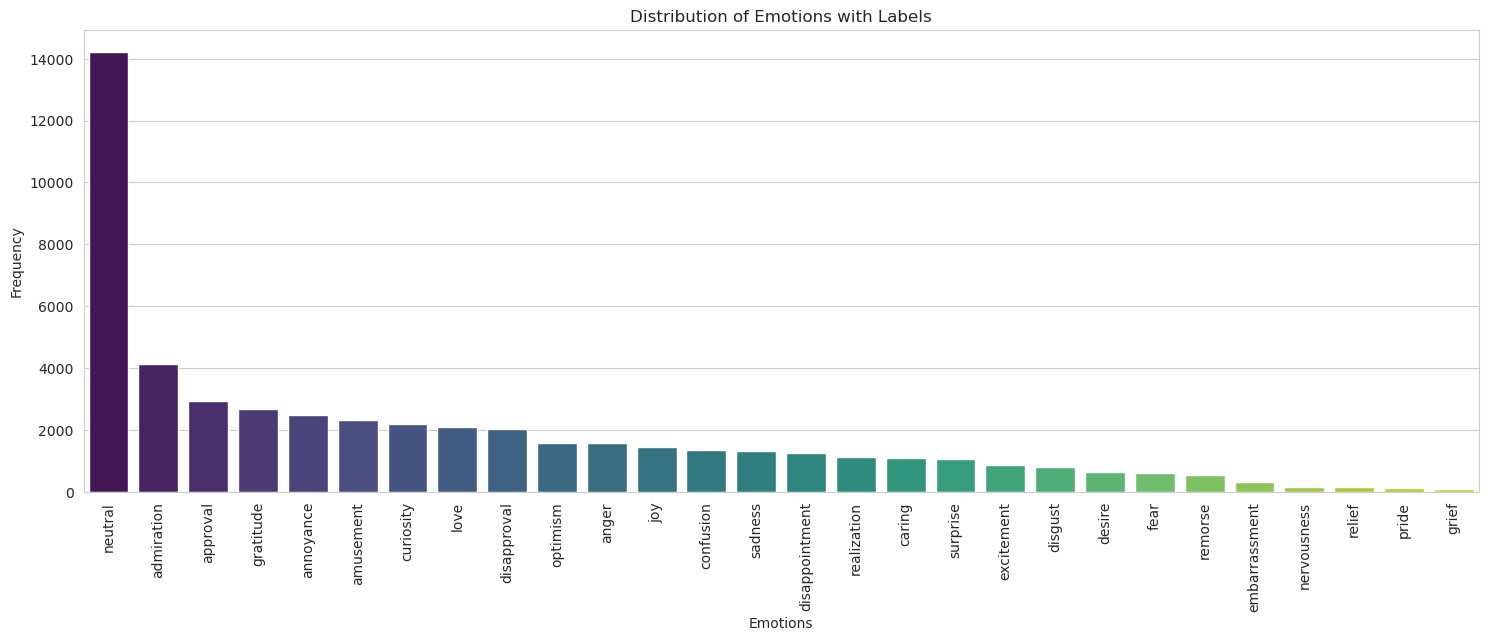

In [53]:
# Creating a mapping of indices to emotion labels
emotion_index_to_label = {index: label for index, label in enumerate(emotion_labels)}

# Applying the mapping to the emotions dataset
labeled_emotions = all_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_emotion_counts = labeled_emotions.value_counts()

# Plotting the distribution of emotions with correct labels and data
plt.figure(figsize=(18, 6))
sns.barplot(x=labeled_emotion_counts.index, y=labeled_emotion_counts.values, hue=labeled_emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions with Labels')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


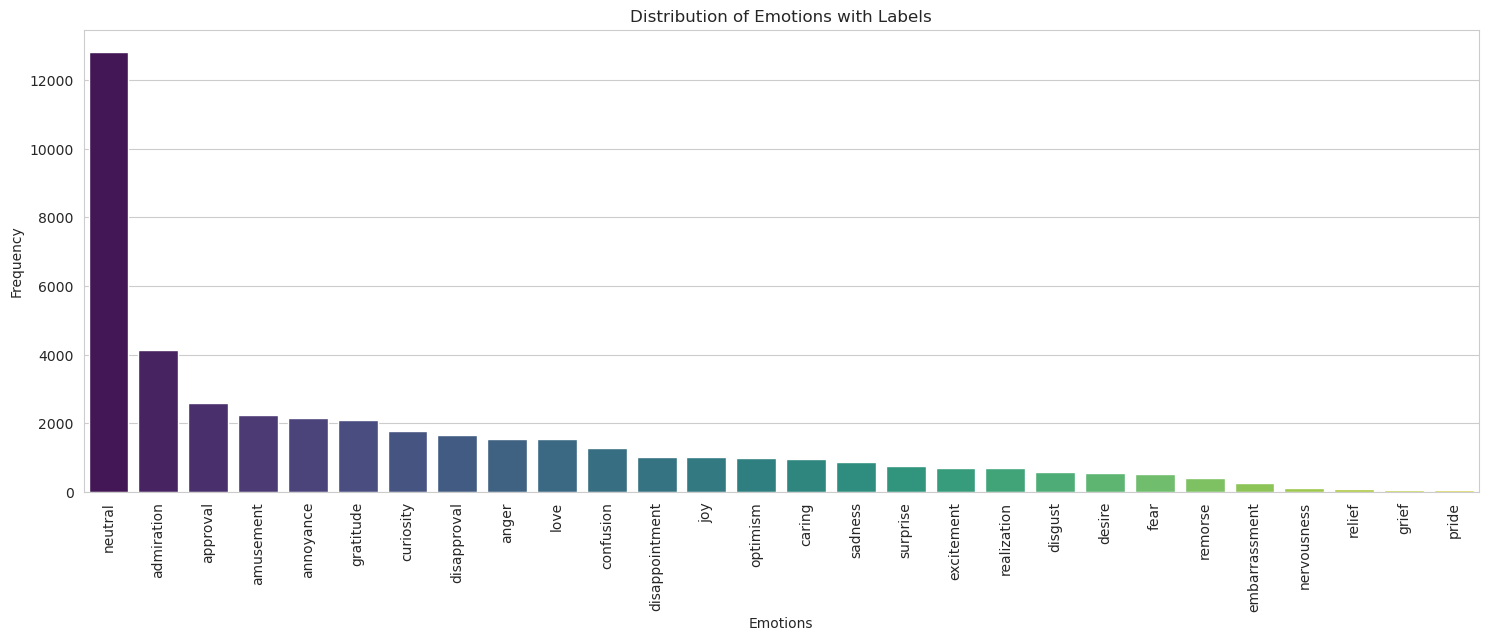

In [43]:
# Extracting only the first emotion label from each row
first_emotions = df_train['emotions'].astype(str).str.split(',').str[0].astype(int)

# Applying the mapping to the emotions dataset
labeled_first_emotions = first_emotions.map(emotion_index_to_label)

# Counting occurrences of each emotion label
labeled_first_emotion_counts = labeled_first_emotions.value_counts()

# Plotting the distribution of emotions with correct labels and data
plt.figure(figsize=(18, 6))
sns.barplot(x=labeled_first_emotion_counts.index, y=labeled_first_emotion_counts.values, hue=labeled_first_emotion_counts.index, palette="viridis", legend=False)
plt.title('Distribution of Emotions with Labels')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [56]:
labeled_emotion_counts

emotions
neutral           14219
admiration         4130
approval           2939
gratitude          2662
annoyance          2470
amusement          2328
curiosity          2191
love               2086
disapproval        2022
optimism           1581
anger              1567
joy                1452
confusion          1368
sadness            1326
disappointment     1269
realization        1110
caring             1087
surprise           1060
excitement          853
disgust             793
desire              641
fear                596
remorse             545
embarrassment       303
nervousness         164
relief              153
pride               111
grief                77
Name: count, dtype: int64

In [73]:
emotion_categories = {
    'Affectionate Emotions': ['love', 'caring', 'admiration', 'approval'],
    'Joyful and Entertaining Emotions': ['amusement', 'joy', 'excitement', 'optimism'],
    'Reflective and Thoughtful Emotions': ['curiosity', 'realization', 'relief', 'desire'],
    'Negative Reactive Emotions': ['annoyance', 'anger', 'disgust', 'fear'],
    'Discontented Emotions': ['disapproval', 'disappointment', 'sadness', 'remorse', 'embarrassment'],
    'Complex or Ambiguous Emotions': ['confusion', 'surprise', 'pride', 'grief', 'nervousness'],
    'Introspective Emotions': ['gratitude', 'relief', 'remorse'],
    'Neutral': ['neutral']
}


emotion_to_category = {}
for category, emotions in emotion_categories.items():
    for emotion in emotions:
        emotion_to_category[emotion] = category

category_counts = pd.Series(dtype=int).reindex(emotion_categories.keys(), fill_value=0)

for emotion, count in labeled_emotion_counts.items():
    category = emotion_to_category[emotion]
    if category:
        category_counts[category] += count
        
category_counts

Affectionate Emotions                 10242
Joyful and Entertaining Emotions       6214
Reflective and Thoughtful Emotions     3942
Negative Reactive Emotions             5426
Discontented Emotions                  4920
Complex or Ambiguous Emotions          2780
Introspective Emotions                 3360
Neutral                               14219
dtype: int64

In [70]:
emotion_to_category

{'Love': 'Affectionate Emotions',
 'Caring': 'Affectionate Emotions',
 'Admiration': 'Affectionate Emotions',
 'Approval': 'Affectionate Emotions',
 'Amusement': 'Joyful and Entertaining Emotions',
 'Joy': 'Joyful and Entertaining Emotions',
 'Excitement': 'Joyful and Entertaining Emotions',
 'Optimism': 'Joyful and Entertaining Emotions',
 'Curiosity': 'Reflective and Thoughtful Emotions',
 'Realization': 'Reflective and Thoughtful Emotions',
 'Relief': 'Introspective Emotions',
 'Desire': 'Reflective and Thoughtful Emotions',
 'Annoyance': 'Negative Reactive Emotions',
 'Anger': 'Negative Reactive Emotions',
 'Disgust': 'Negative Reactive Emotions',
 'Fear': 'Negative Reactive Emotions',
 'Disapproval': 'Discontented Emotions',
 'Disappointment': 'Discontented Emotions',
 'Sadness': 'Discontented Emotions',
 'Remorse': 'Introspective Emotions',
 'Embarrassment': 'Discontented Emotions',
 'Pride': 'Socially-Driven Emotions',
 'Grief': 'Socially-Driven Emotions',
 'Nervousness': 'Socia

In [104]:
train_df['emotions'].value_counts().head(35)

emotions
27       12823
0         2710
4         1873
15        1857
1         1652
3         1451
18        1427
10        1402
7         1389
2         1025
20         861
6          858
17         853
25         817
26         720
9          709
5          649
22         586
13         510
11         498
14         430
8          389
24         353
2,3        230
0,15       227
12         203
0,4        199
4,27       190
6,7        174
0,18       155
3,10       148
3,27       123
10,27      104
9,25       103
7,27       102
Name: count, dtype: int64